# Time Series Prediction with EDA

<p align="center">
    <img width="600" height="1" src="https://i.ibb.co/Jkqyc38/ww2.png">
</p>

## INTRODUCTION

<font color='red'>Content:</font>

- [Load the Data](#1)
- [Data Description](#3)
- [Data Cleaning](#4)
- [Data Visualization](#5)
- [Time Series Prediction with ARIMA](#6)
    - [What is Time Series ?](#7)
    - [Stationarity of a Time Series](#8)
    - [Make a Time Series Stationary](#9)
        - [Moving Average method](#10)
        - [Differencing method](#11)
        - [Forecasting a Time Series](#12)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization library
import matplotlib.pyplot as plt # visualization library
import plotly.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("Aerial Bombing Operations in WWII/"))
# import warnings library
import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
plt.style.use('ggplot') # style of plots. ggplot is one of the most used style, I also like it.
# Any results you write to the current directory are saved as output.

['operations.csv', 'Summary of Weather.csv', 'Weather Station Locations.csv']


### <a name="1"></a>Load the Data


- As I mentioned at introduction, we use multiple data sources.
    - Aerial Bombing Operations in WW2
        - Shortly, this data includes bombing operations. For example, USA who use ponte olivo airfield bomb Germany (Berlin) with A36 air craft in 1945.
    - Wether Conditions in WW2
        - Shortly, weather conditions during ww2. For example, according to george town weather station, average temperature is 23.88 in 1/7/1942.
        - This data set has 2 subset in it. First one includes weather station locations like country, latitude and longitude.
        - Second one includes measured min, max and mean temperatures from weather stations.

In [3]:
# bombing data
aerial = pd.read_csv("Aerial Bombing Operations in WWII/operations.csv")
# first weather data that includes locations like country, latitude and longitude.
weather_station_location = pd.read_csv("Aerial Bombing Operations in WWII/Weather Station Locations.csv")
# Second weather data that includes measured min, max and mean temperatures
weather = pd.read_csv("Aerial Bombing Operations in WWII/Summary of Weather.csv")

### <a name="3"></a>Data Description


- __Aerial bombing Data description:__
    - Mission Date: Date of mission
    - Theater of Operations: Region in which active military operations are in progress; "the army was in the field awaiting action"; Example: "he served in the Vietnam theater for three years"
    - Country: Country that makes mission or operation like USA
    - Air Force: Name or id of air force unity like 5AF
    - Aircraft Series: Model or type of aircraft like B24
    - Callsign: Before bomb attack, message, code, announcement, or tune that is broadcast by radio.
    - Takeoff Base: Takeoff airport name like Ponte Olivo Airfield
    - Takeoff Location: takeoff region Sicily
    - Takeoff Latitude: Latitude of takeoff region
    - Takeoff Longitude: Longitude of takeoff region
    - Target Country: Target country like Germany
    - Target City: Target city like Berlin
    - Target Type: Type of target like city area
    - Target Industry: Target industy like town or urban
    - Target Priority: Target priority like 1 (most)
    - Target Latitude: Latitude of target
    - Target Longitude: Longitude of target
- __Weather Condition data description:__
    - Weather station location:
        - WBAN: Weather station number
        - NAME: weather station name
        - STATE/COUNTRY ID: acronym of countries
        - Latitude: Latitude of weather station
        - Longitude: Longitude of weather station
    - Weather:
        - STA: eather station number (WBAN)
        - Date: Date of temperature measurement
        - MeanTemp: Mean temperature

### <a name="4"></a>Data Cleaning


- Aerial Bombing data includes a lot of NaN value. Instead of usign them, I drop some NaN values. It does not only remove the uncertainty but it also easa visualization process.
    - Drop countries that are NaN
    - Drop if target longitude is NaN
    - Drop if takeoff longitude is NaN
    - Drop unused features
- Weather Condition data does not need any cleaning. According to exploratory data analysis and visualization, we will choose certain location to examine deeper. However, lets put our data variables what we use only.

In [4]:
# drop countries that are NaN
aerial = aerial[pd.isna(aerial.Country)==False]
# drop if target longitude is NaN
aerial = aerial[pd.isna(aerial['Target Longitude'])==False]
# Drop if takeoff longitude is NaN
aerial = aerial[pd.isna(aerial['Takeoff Longitude'])==False]
# drop unused features
drop_list = ['Mission ID','Unit ID','Target ID','Altitude (Hundreds of Feet)','Airborne Aircraft',
             'Attacking Aircraft', 'Bombing Aircraft', 'Aircraft Returned',
             'Aircraft Failed', 'Aircraft Damaged', 'Aircraft Lost',
             'High Explosives', 'High Explosives Type','Mission Type',
             'High Explosives Weight (Pounds)', 'High Explosives Weight (Tons)',
             'Incendiary Devices', 'Incendiary Devices Type',
             'Incendiary Devices Weight (Pounds)',
             'Incendiary Devices Weight (Tons)', 'Fragmentation Devices',
             'Fragmentation Devices Type', 'Fragmentation Devices Weight (Pounds)',
             'Fragmentation Devices Weight (Tons)', 'Total Weight (Pounds)',
             'Total Weight (Tons)', 'Time Over Target', 'Bomb Damage Assessment','Source ID']
aerial.drop(drop_list, axis=1,inplace = True)
aerial = aerial[ aerial.iloc[:,8]!="4248"] # drop this takeoff latitude 
aerial = aerial[ aerial.iloc[:,9]!=1355]   # drop this takeoff longitude

In [5]:
aerial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2555 entries, 0 to 178080
Data columns (total 17 columns):
Mission Date             2555 non-null object
Theater of Operations    2555 non-null object
Country                  2555 non-null object
Air Force                2505 non-null object
Aircraft Series          2528 non-null object
Callsign                 10 non-null object
Takeoff Base             2555 non-null object
Takeoff Location         2555 non-null object
Takeoff Latitude         2555 non-null object
Takeoff Longitude        2555 non-null float64
Target Country           2499 non-null object
Target City              2552 non-null object
Target Type              602 non-null object
Target Industry          81 non-null object
Target Priority          230 non-null object
Target Latitude          2555 non-null float64
Target Longitude         2555 non-null float64
dtypes: float64(3), object(14)
memory usage: 359.3+ KB


In [6]:
# what we will use only
weather_station_location = weather_station_location.loc[:,["WBAN","NAME","STATE/COUNTRY ID","Latitude","Longitude"] ]
weather_station_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 5 columns):
WBAN                161 non-null int64
NAME                161 non-null object
STATE/COUNTRY ID    161 non-null object
Latitude            161 non-null float64
Longitude           161 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.4+ KB


In [7]:
# what we will use only
weather = weather.loc[:,["STA","Date","MeanTemp"] ]
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
STA         119040 non-null int64
Date        119040 non-null object
MeanTemp    119040 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


### <a name="5"></a>Data Visualization


- Lets start with basics of visualization that is understanding data.
    - How many country which attacks
    - Top target countries
    - Top 10 aircraft series
    - Takeoff base locations (Attacjk countries)
    - Target locations 
    - Bombing paths
    - Theater of Operations
    - Weather station locations

USA              1895
GREAT BRITAIN     544
NEW ZEALAND       102
SOUTH AFRICA       14
Name: Country, dtype: int64


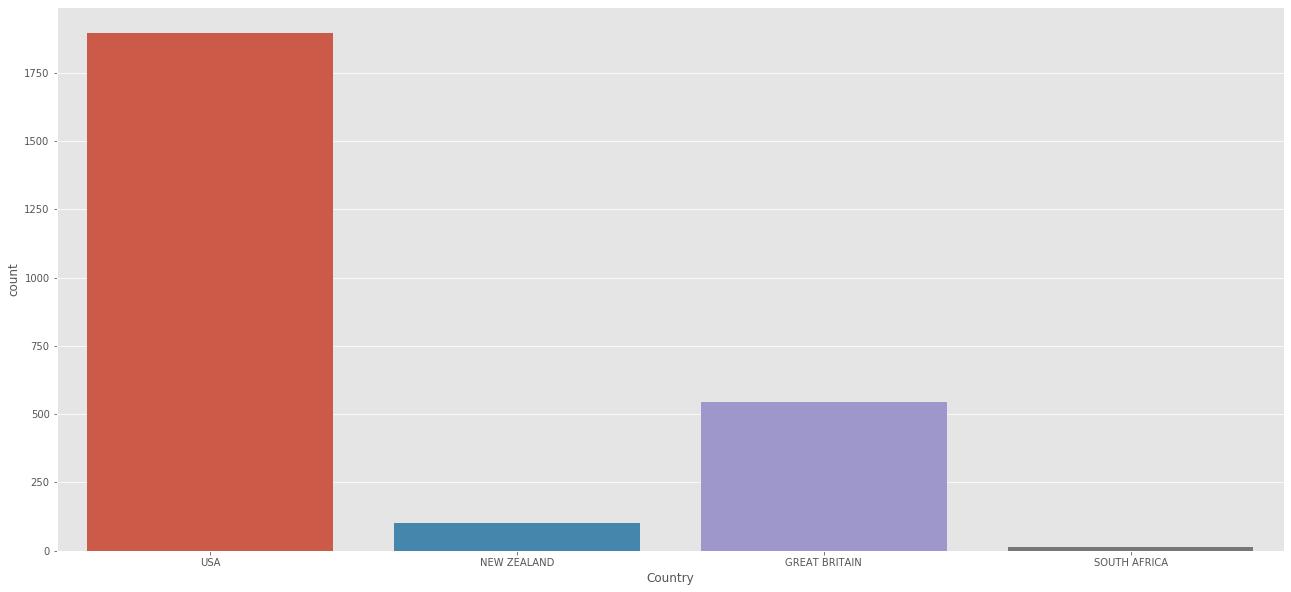

In [8]:
# country
print(aerial['Country'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(aerial['Country'])
plt.show()

ITALY      1104
BURMA       335
LIBYA       272
TUNISIA     113
GREECE       87
EGYPT        80
JAPAN        71
CHINA        52
SICILY       46
GERMANY      41
Name: Target Country, dtype: int64


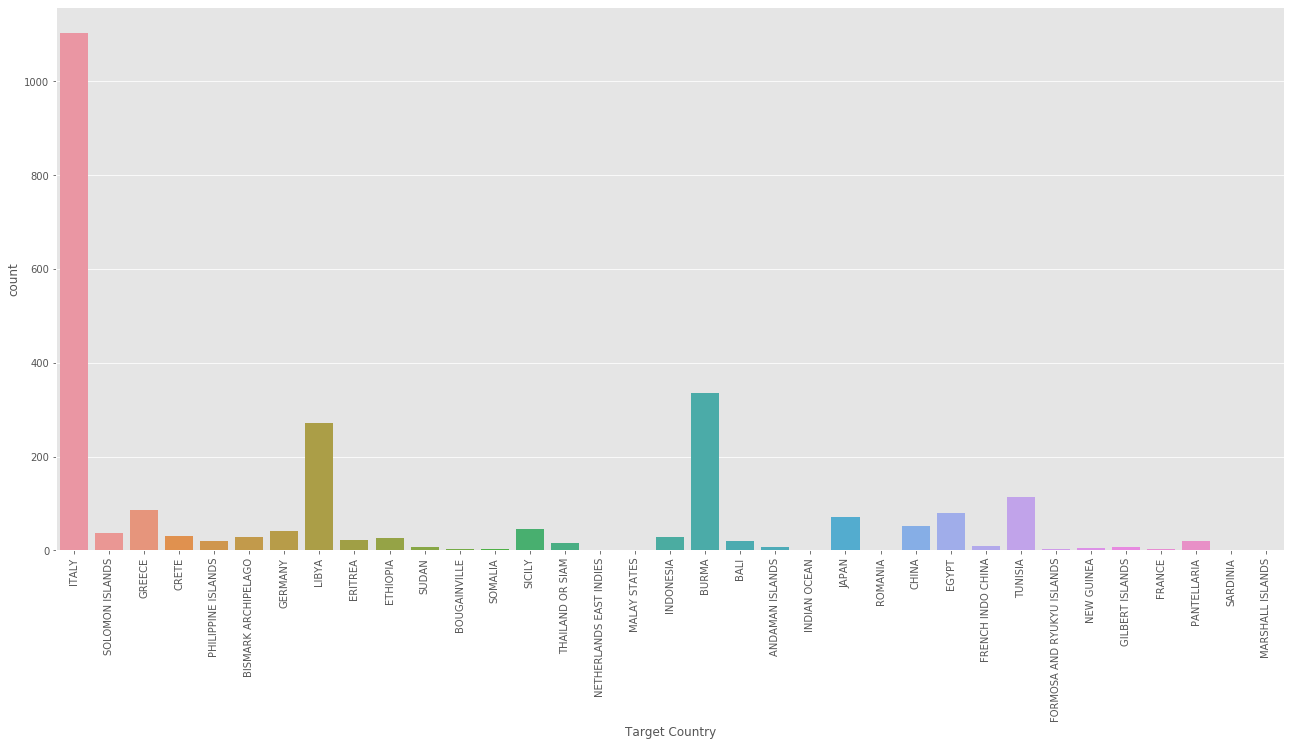

In [9]:
# Top target countries
print(aerial['Target Country'].value_counts()[:10])
plt.figure(figsize=(22,10))
sns.countplot(aerial['Target Country'])
plt.xticks(rotation=90)
plt.show()

In [10]:
# Aircraft Series
data = aerial['Aircraft Series'].value_counts()
print(data[:10])
data = [go.Bar(
            x=data[:10].index,
            y=data[:10].values,
            hoverinfo = 'text',
            marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
    )]

layout = dict(
    title = 'Aircraft Series',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

A36             990
B25             416
B24             337
BLEN            180
LIB             145
WELL            129
B17             119
PV-1 VENTURA     70
WHIT             32
HALI             18
Name: Aircraft Series, dtype: int64


- Most used air craft: A36
<p align="left">
        <img width="400" height="300" src="https://lh3.googleusercontent.com/proxy/6LQ7FQRRnBHFj96w3gWbdflbIpSDKAabrCBuunyPeoTLcnuedUq8rhvUbOoPDR-bMl4yHATvpjzwR3vpYaFZGbM0y-3SUhYAejqx_h5khkIR">
      </p>

- Now lets visualize take off bases of countries who attack
    - In plot below, blue color draw the attention, it is USA and red color is Great Britain

In [11]:
aerial.head()

,Mission Date,Theater of Operations,Country,Air Force,Aircraft Series,Callsign,Takeoff Base,Takeoff Location,Takeoff Latitude,Takeoff Longitude,Target Country,Target City,Target Type,Target Industry,Target Priority,Target Latitude,Target Longitude
0,8/15/1943,MTO,USA,12 AF,A36,NaN,PONTE OLIVO AIRFIELD,SICILY,37.131022,14.321464,ITALY,SPADAFORA,NaN,NaN,NaN,38.22,15.37
2,8/15/1943,MTO,USA,12 AF,A36,NaN,PONTE OLIVO AIRFIELD,SICILY,37.131022,14.321464,ITALY,COSENZA,NaN,NaN,NaN,39.27,16.25
3,8/15/1943,MTO,USA,12 AF,A36,NaN,PONTE OLIVO AIRFIELD,SICILY,37.131022,14.321464,ITALY,GIOJA TAURO,NaN,NaN,NaN,38.43,15.90
8,8/15/1943,MTO,USA,12 AF,A36,NaN,PONTE OLIVO AIRFIELD,SICILY,37.131022,14.321464,ITALY,SCILLA,NaN,NaN,NaN,38.23,15.72
9,8/15/1943,MTO,USA,12 AF,A36,NaN,PONTE OLIVO AIRFIELD,SICILY,37.131022,14.321464,ITALY,GIOJA TAURO,NaN,ARMAMENT AND ORDNANCE PLANTS,NaN,38.43,15.90


MTO            1802
CBI             425
PTO             247
ETO              44
EAST AFRICA      37
Name: Theater of Operations, dtype: int64


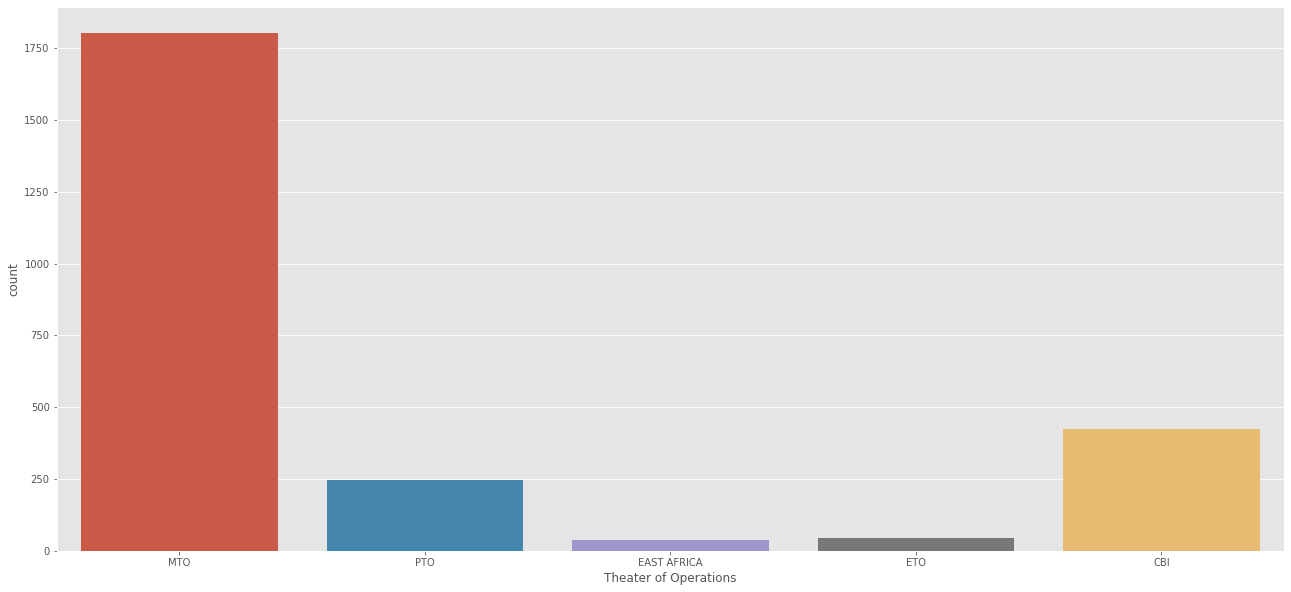

In [18]:
#Theater of Operations
print(aerial['Theater of Operations'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(aerial['Theater of Operations'])
plt.show()

- Lets focus USA and BURMA war
- In this war USA bomb BURMA( KATHA city) from 1942 to 1945.
- The closest weather station to this war is BINDUKURI and it has temperature record from 1943 to 1945.
- Now lets visualize this situation. But before visualization, we need to make date features date time object

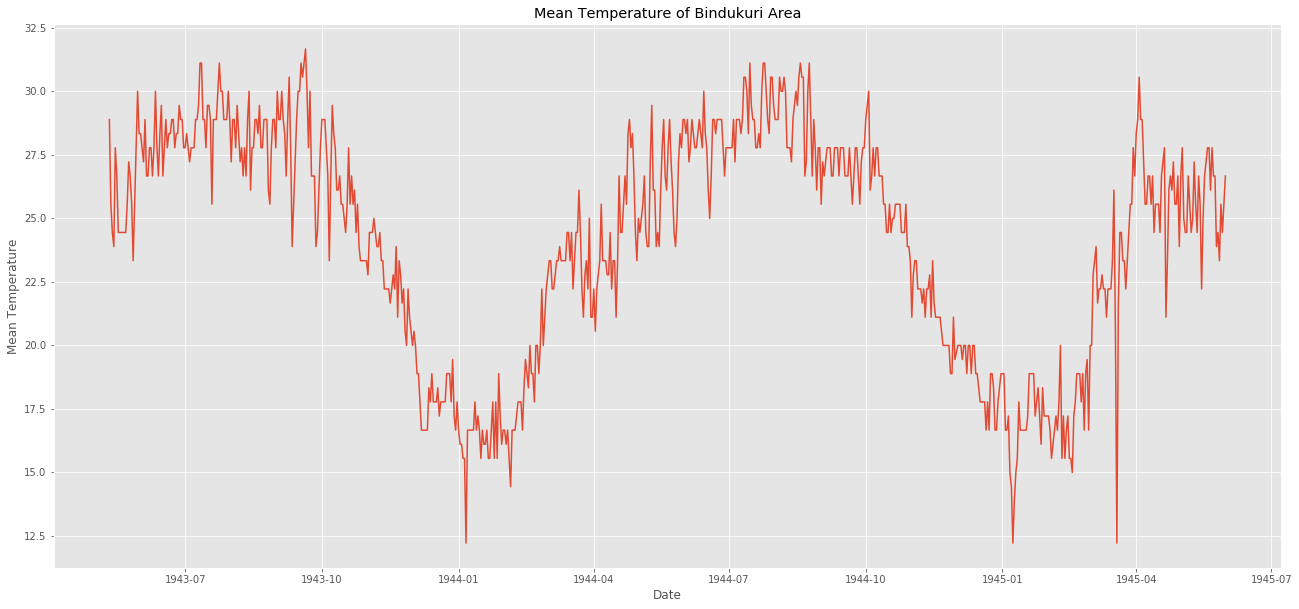

In [19]:
weather_station_id = weather_station_location[weather_station_location.NAME == "BINDUKURI"].WBAN 
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

- As you can see, we have temperature measurement from 1943 to 1945.
- Temperature ossilates between 12 and 32 degrees.
- Temperature of winter months is colder than temperature of summer months.

### <a name="6"></a>Time Series Prediction with ARIMA


- We will use most used method ARIMA
- ARIMA : AutoRegressive Integrated Moving Average. I will explain it detailed at next parts.
- The way that we will follow:
    - What is Time Series ?
    - Stationarity of a Time Series
    - Make a Time Series Stationary?
    - Forecasting a Time Series




### <a name="7"></a>What is Time Series ?
- Time series is a collection of data points that are collected at constant time intervals.
- It is time dependent.
- Most of time series have some form of __seasonality trends__. For example, if we sale ice cream, most probably there will be higher sales in summer seasons. Therefore, this time series has seasonality trends.
- Another example, lets think we dice one time every day during 1 year. As you guess, there will be no scenario like that number six is appeared mostly in summer season or number five is mostly appeared in January. Therefore, this time series does not have seasonality trends.



### <a name="8"></a>Stationarity of a Time Series
- There are three basic criterion for a time series to understand whether it is stationary series or not.
    - Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary
        - constant mean
        - constant variance
        - autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.
- Lets visualize and check seasonality trend of our time series.


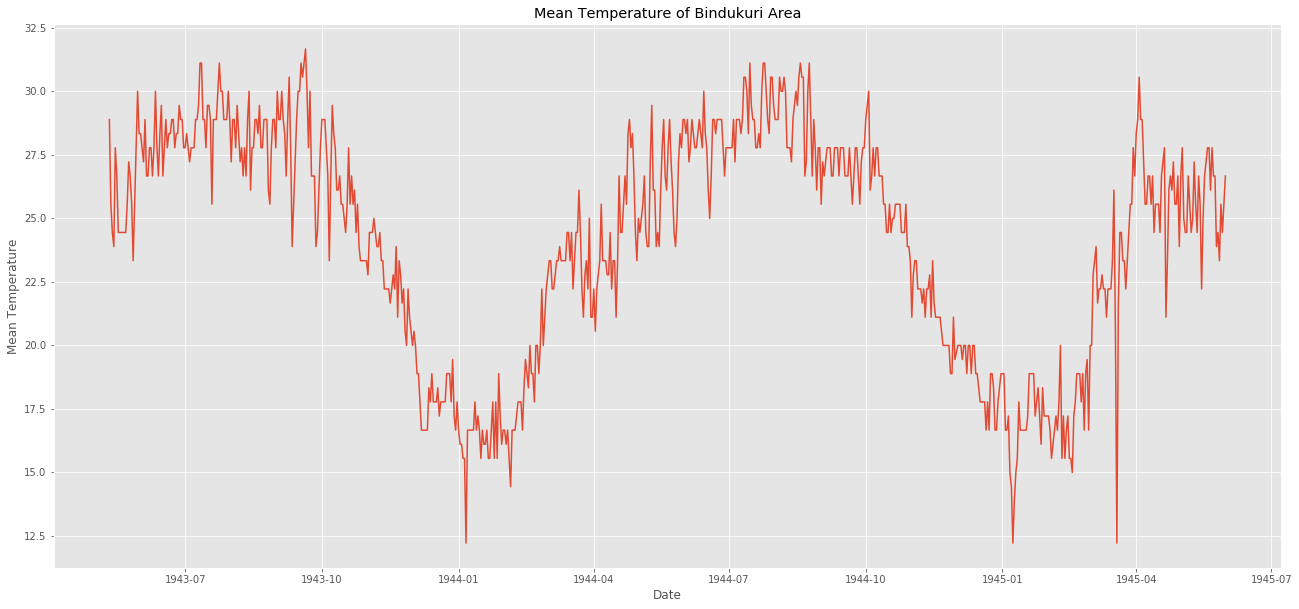

In [20]:
# Mean temperature of Bindikuri area
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

# lets create time series from weather 
timeSeries = weather_bin.loc[:, ["Date","MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date",axis=1)


- As you can see from plot above, our time series has seasonal variation. In summer, mean temperature is higher and in winter mean temperature is lower for each year.
- Now lets check stationary of time series. We can check stationarity using the following methods:
    - Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.
    - Dickey-Fuller Test: The test results comprise of a __Test Statistic__ and some __Critical Values__ for difference confidence levels. If the test __statistic__ is less than the __critical value__, we can say that time series is stationary.

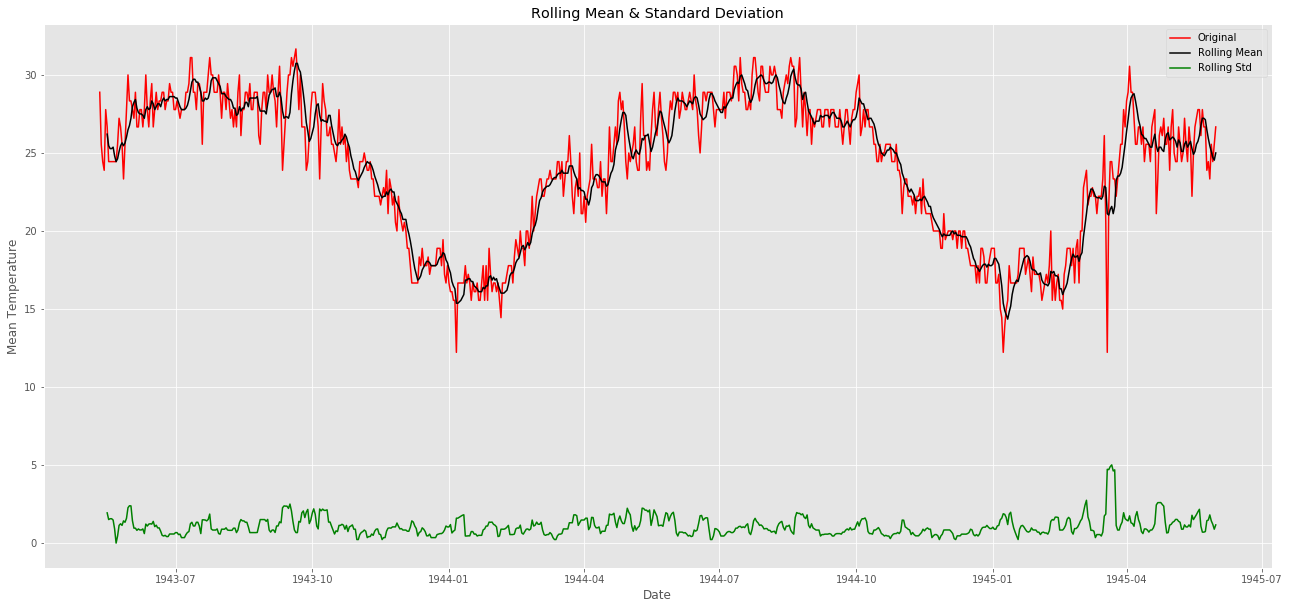

Test statistic:  -1.4095966745887747
p-value:  0.577666802852636
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


In [23]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
#     rolmean = pd.rolling_mean(ts, window=6)
    rolmean = ts.rolling(window=6).mean()
#     rolstd = pd.rolling_std(ts, window=6)
    rolstd = ts.rolling(window=6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts)
check_adfuller(ts.MeanTemp)

- Our first criteria for stationary is constant mean. So we fail because mean is not constant as you can see from plot(black line) above . (no stationary)
- Second one is constant variance. It looks like constant. (yes stationary)
- Third one is that If the test statistic is less than the critical value, we can say that time series is stationary. Lets look:
    - test statistic = -1.4 and critical values = {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}. Test statistic is bigger than the critical values. (no stationary)
- As a result, we sure that our time series is not stationary.
- Lets make time series stationary at the next part.

### <a name="9"></a>Make a Time Series Stationary?


- As we mentioned before, there are 2 reasons behind non-stationarity of time series
    - Trend: varying mean over time. We need constant mean for stationary of time series.
    - Seasonality: variations at specific time. We need constant variations for stationary of time series.
- First solve trend(constant mean) problem
    - Most popular method is moving average.
        - Moving average: We have window that take the average over the past 'n' sample. 'n' is window size.

### <a name="10"></a>Moving Average method


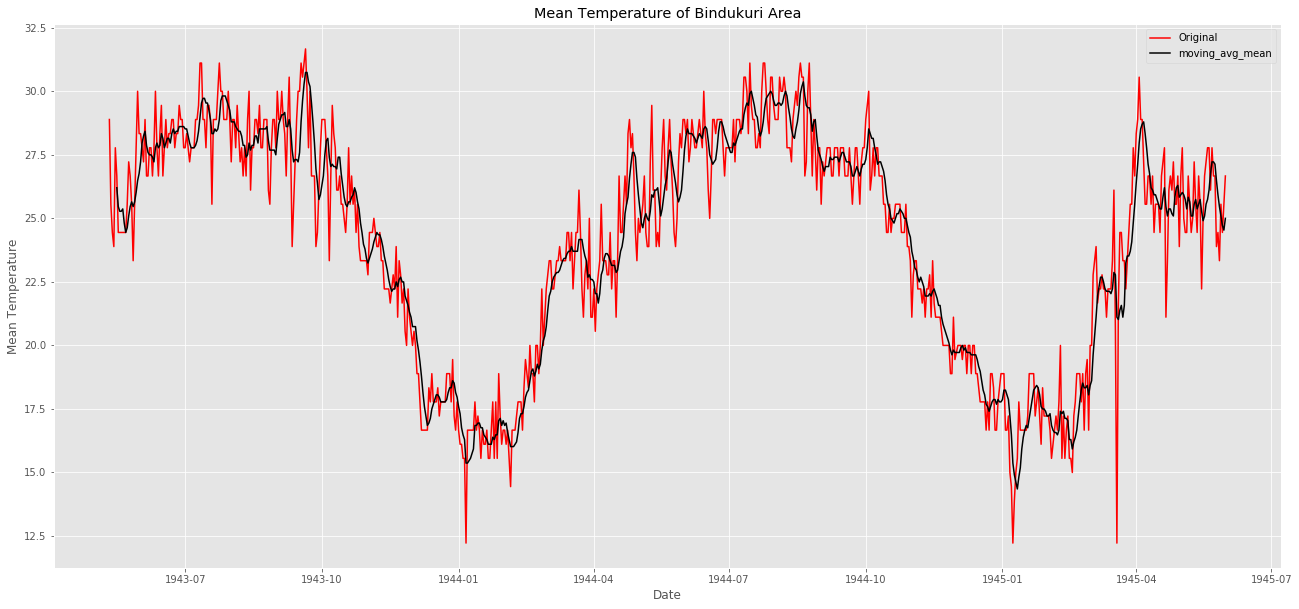

In [26]:
# Moving average method
window_size = 6
moving_avg = ts.rolling(window_size).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

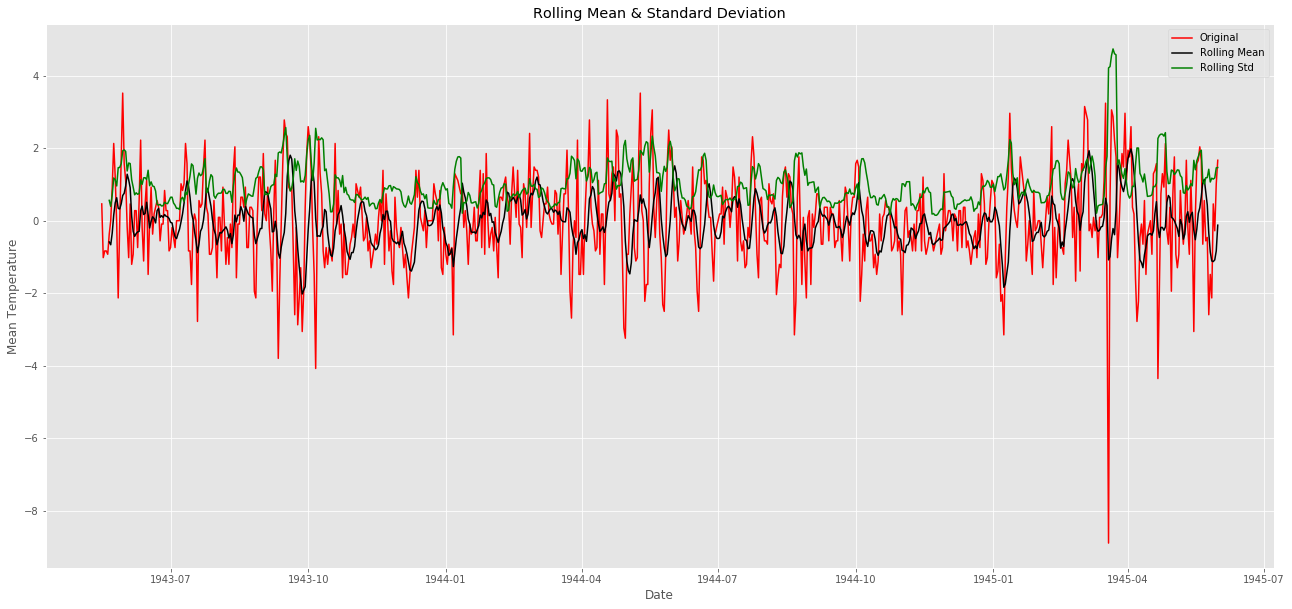

Test statistic:  -11.138514335138474
p-value:  3.150868563164652e-20
Critical Values: {'1%': -3.4392539652094154, '5%': -2.86546960465041, '10%': -2.5688625527782327}


In [27]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 6 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff.MeanTemp)

- Constant mean criteria: mean looks like constant as you can see from plot(black line) above . (yes stationary)
- Second one is constant variance. It looks like constant. (yes stationary)
- The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)
- We achieve stationary time series. However lets look at one more method to avoid trend and seasonality.
    - Differencing method: It is one of the most common method. Idea is that take difference between time series and shifted time series.

### <a name="11"></a>Differencing method


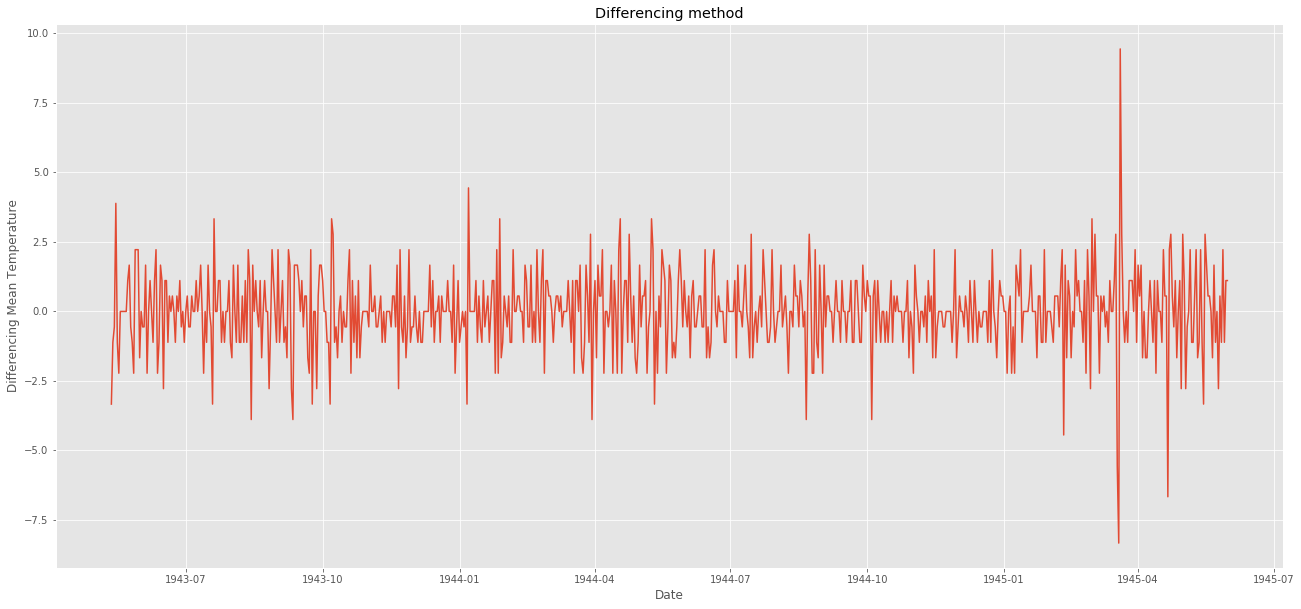

In [28]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

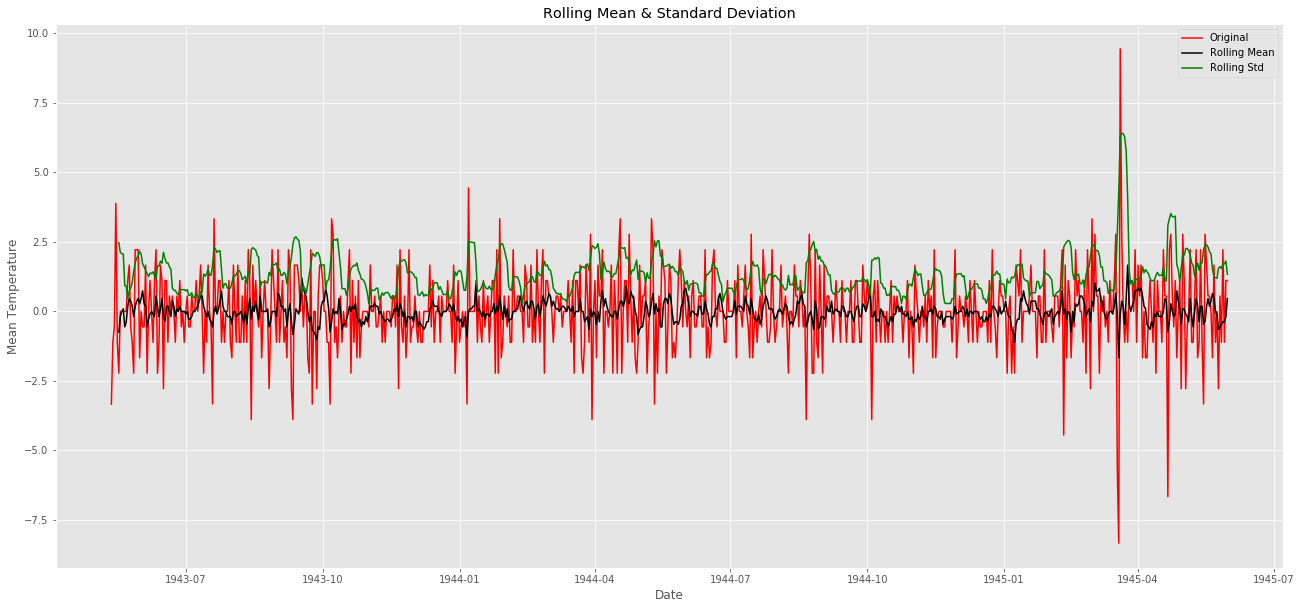

Test statistic:  -11.678955575105366
p-value:  1.760207569355997e-21
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


In [29]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff.MeanTemp)

- Constant mean criteria: mean looks like constant as you can see from plot(black line) above . (yes stationary)
- Second one is constant variance. It looks like constant. (yes stationary)
- The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)

### <a name="12"></a>Forecasting a Time Series

- We learn two different methodsthat are moving average and differencing methods to avoid trend and seasonality problem
- For prediction(forecasting) we will use ts_diff time series that is result of differencing method. There is no reason I only choose it.
- Also prediction method is ARIMA that is Auto-Regressive Integrated Moving Averages.
    - AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
    - I: Integrated (d): These are the number of nonseasonal differences. For example, in our case we take the first order difference. So we pass that variable and put d=0
    - MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.
- (p,d,q) is parameters of ARIMA model.
- In order to choose p,d,q parameters we will use two different plots.
    - Autocorrelation Function (ACF): Measurement of the correlation between time series and lagged version of time series.
    - Partial Autocorrelation Function (PACF): This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.

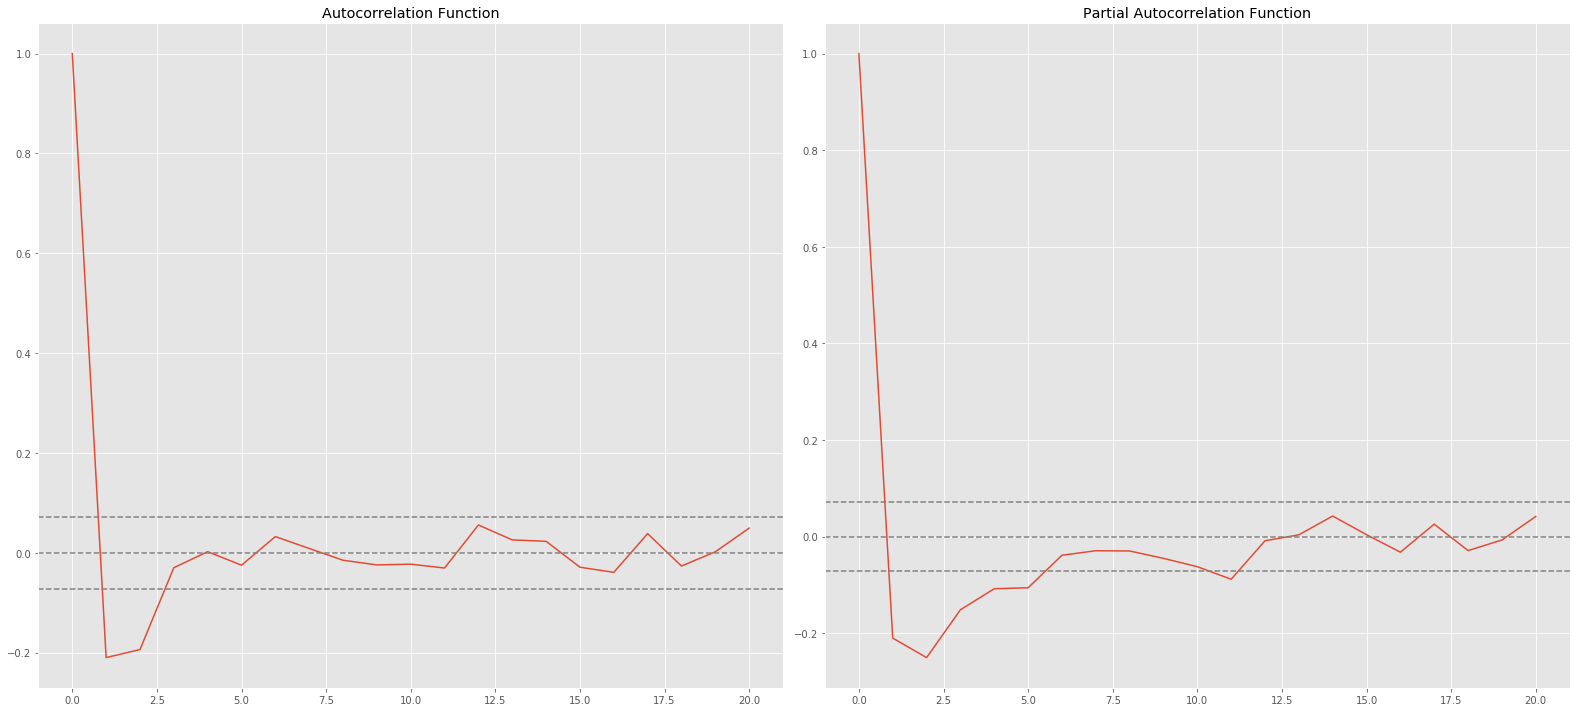

In [30]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

- Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values
    - Choosing p: The lag value where the PACF chart crosses the upper confidence interval for the first time. p=1.
    - Choosing q: The lag value where the ACF chart crosses the upper confidence interval for the first time. q=1.
- Now lets use (1,0,1) as parameters of ARIMA models and predict
    - ARIMA: from statsmodels libarary
    - datetime: we will use it start and end indexes of predict method

- lets predict and visualize all path and find mean squared error


error:  1.8625819456373405


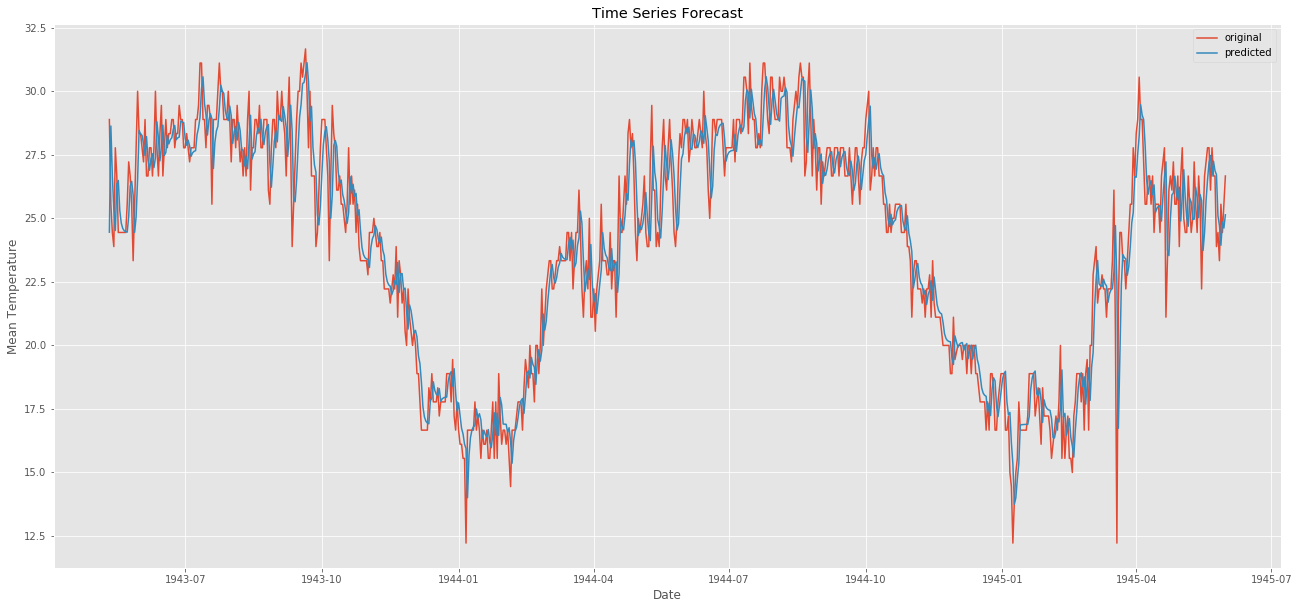

In [32]:
# predict all path
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(ts, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit(disp=0)
forecast2 = model_fit2.predict()
error = mean_squared_error(ts, forecast2)
print("error: " ,error)
# visualization
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp,label = "original")
plt.plot(forecast2,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.savefig('graph.png')

plt.show()

## CONCLUSION